In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Loading Data

In [2]:
# choose a list of 35 countries to train global model
countries = ['Germany', 'France', 'Australia', 'Brazil', 'Italy', 'Spain',
       'Canada', 'Netherlands', 'Switzerland', 'India', 'Sweden',
       'South Africa', 'Mexico', 'Japan', 'Belgium', 'Russia', 'Poland',
       'Portugal', 'Finland', 'Czech Republic', 'Denmark', 'New Zealand',
       'Austria', 'Argentina', 'Norway', 'Indonesia', 'Chile', 'Colombia',
       'Israel', 'Costa Rica', 'Peru', 'Estonia', 'Croatia', 'Ukraine',
       'Puerto Rico']

In [3]:
def compute_percent_change_features(country_list, start_date, train_date, test_date):
    def percent_change(new, original):
        return (new - original) / original
    
    # store dataframes in lists
    df_list = []

    for country in countries:
        country_df = pd.read_csv(f'{country}_biodiversity_research_sigmoid.csv')
        
        # check if there's no organizations, if so use number of occurences of country as backup
        for index, orgs in enumerate(country_df['Country Specific Orgs']):
            if orgs == 0:
                country_df.at[index, 'Country Specific Orgs'] = str(country_df.at[index, 'Addresses']).count(country)
        
        country_df = country_df.drop(columns=['Country Specific Authors'])
        country_df = country_df[country_df['Country Specific Orgs'] > 0]
        country_df = country_df.reset_index(drop=True)

        # get papers from 1998 and onwards
        country_df = country_df[country_df['Publication Year'] >= 1998]
        country_df = country_df.reset_index(drop=True)
        df_list.append(country_df)

    country_train = []
    country_test = []

    for country_data in df_list:
        train_data = pd.DataFrame(dict({'Year': np.zeros(train_date - 1998 + 1), 'Paper Volume': np.zeros(train_date - 1998 + 1), 'Mean Adj. Citations': np.zeros(train_date - 1998 + 1), 'Mean Orgs': np.zeros(train_date - 1998 + 1)}))
        test_data = pd.DataFrame(dict({'Year': np.zeros(test_date - train_date + 1), 'Paper Volume': np.zeros(test_date - train_date + 1), 'Mean Adj. Citations': np.zeros(test_date - train_date + 1), 'Mean Orgs': np.zeros(test_date - train_date + 1)}))
        for date in range(1998, test_date + 1):
            year_data = country_data[country_data['Publication Year'] == date]
            year_data = year_data.reset_index(drop=True)

            if date < train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            elif date == train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            else:
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]

        country_train.append(train_data)
        country_test.append(test_data)
    
    protected_df = pd.read_csv('protected_land_cleaned.csv')
    
    # now compute the percent changes starting from start_date (i.e. can start analysis in start_date + 1)
    
    percent_change_train = []
    percent_change_test = []
    percent_change_protected_test = []
    percent_change_protected_train = []

    for train_df in country_train:
        percent_train = pd.DataFrame(dict({'Change_Volume': np.zeros(train_date - start_date), 'Change_Citations': np.zeros(train_date - start_date), 'Change_Orgs': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            percent_train.iloc[i] = [percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Paper Volume'], train_df.iloc[start_date - 1998 + i]['Paper Volume']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Adj. Citations'], train_df.iloc[start_date - 1998 + i]['Mean Adj. Citations']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Orgs'], train_df.iloc[start_date - 1998 + i]['Mean Orgs'])]
        percent_change_train.append(percent_train)

    for test_df in country_test:    
        percent_test = pd.DataFrame(dict({'Change_Volume': np.zeros(test_date - train_date), 'Change_Citations': np.zeros(test_date - train_date), 'Change_Orgs': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            percent_test.iloc[i] = [percent_change(test_df.iloc[1 + i]['Paper Volume'], test_df.iloc[i]['Paper Volume']), percent_change(test_df.iloc[1 + i]['Mean Adj. Citations'], test_df.iloc[i]['Mean Adj. Citations']), percent_change(test_df.iloc[1 + i]['Mean Orgs'], test_df.iloc[i]['Mean Orgs'])]
        percent_change_test.append(percent_test)

    global_df = protected_df[protected_df['Country'] == 'World']
    
    for country in countries:
        country_protected = protected_df[protected_df['Country'] == country]
        country_protected = country_protected[country_protected['Year'] >= start_date]
        country_protected = country_protected[country_protected['Year'] <= test_date]
        country_protected = country_protected.reset_index(drop=True)
        
        protect_change_train = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            protect_change_train.iloc[i] = [percent_change(country_protected.iloc[1 + i]['Value'], country_protected.iloc[0 + i]['Value']) / 
                                            percent_change(global_df.iloc[1 + i]['Value'], global_df.iloc[0 + i]['Value'])]
        percent_change_protected_train.append(protect_change_train)

        protect_change_test = pd.DataFrame(dict({'Change_Protected_Percent': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            protect_change_test.iloc[i] = [percent_change(country_protected.iloc[train_date - start_date + 1 + i]['Value'], country_protected.iloc[train_date - start_date + i]['Value']) /
                                           percent_change(global_df.iloc[train_date - start_date + 1 + i]['Value'], global_df.iloc[train_date - start_date + i]['Value'])]
        percent_change_protected_test.append(protect_change_test)
        
    return percent_change_train, percent_change_test, percent_change_protected_train, percent_change_protected_test

In [4]:
X_train_list, X_test_list, y_train_list, y_test_list = compute_percent_change_features(countries, 2000, 2014, 2021)

C:\Users\btiv\AppData\Local\Temp/ipykernel_36336/1301066001.py:9: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_36336/1301066001.py:9: DtypeWarning: Columns (6,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_36336/1301066001.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_36336/1301066001.py:9: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
C:\Users\btiv\AppData\Local\Temp/ipykernel_36336/13010660

In [5]:
def calc_MSE(y_pred, y_true):
    return (1/len(y_pred))*((np.array(y_pred)-np.array(y_true))**2).sum()

def calc_MAE(y_pred, y_true):
    return (1/len(y_pred))*(abs(np.array(y_pred)-np.array(y_true))).sum()

In [6]:
def shift_data(shift, X_train_list, X_test_list, y_train_list, y_test_list):
    X_shifted_train_list = []
    X_shifted_test_list = []
    y_shifted_train_list = []
    y_shifted_test_list = []
    
    for index, df in enumerate(X_train_list):
        X_shifted = X_train_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_train_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_train_list.append(X_shifted)
        y_shifted_train_list.append(y_train_list[index][shift:])
    
    for index, df in enumerate(X_test_list):
        X_shifted = X_test_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_test_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change_Volume_Prev_{shift_i + 1}', f'Change_Citations_Prev_{shift_i + 1}', f'Change_Orgs_Prev_{shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_test_list.append(X_shifted)
        y_shifted_test_list.append(y_test_list[index][shift:])
    
    return X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list

In [7]:
X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list = shift_data(3, X_train_list, X_test_list, y_train_list, y_test_list)

In [8]:
def aggregate_data(X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list):
    X_train_agg = X_shifted_train_list[0]
    X_test_agg = X_shifted_test_list[0]
    y_train_agg = y_shifted_train_list[0]
    y_test_agg = y_shifted_test_list[0]
    for i in range(1, len(X_shifted_train_list)):
        X_train_agg = pd.concat([X_train_agg, X_shifted_train_list[i]])
        X_test_agg = pd.concat([X_test_agg, X_shifted_test_list[i]])
        y_train_agg = pd.concat([y_train_agg, y_shifted_train_list[i]])
        y_test_agg = pd.concat([y_test_agg, y_shifted_test_list[i]])
    
    X_train_agg = X_train_agg.reset_index(drop=True)
    X_test_agg = X_test_agg.reset_index(drop=True)
    y_train_agg = y_train_agg.reset_index(drop=True)
    y_test_agg = y_test_agg.reset_index(drop=True)
    
    return X_train_agg, X_test_agg, y_train_agg, y_test_agg

In [9]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = aggregate_data(X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list)

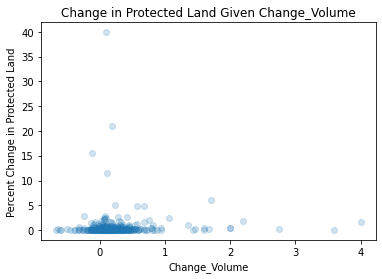

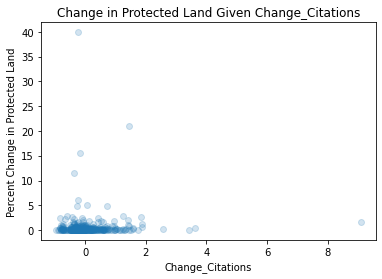

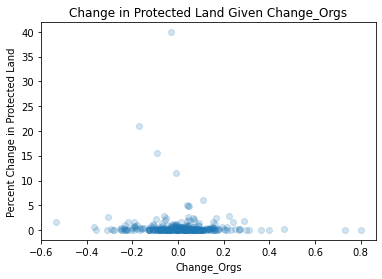

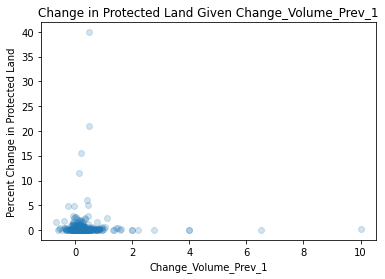

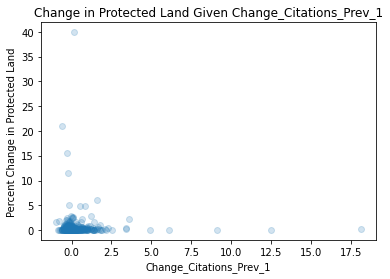

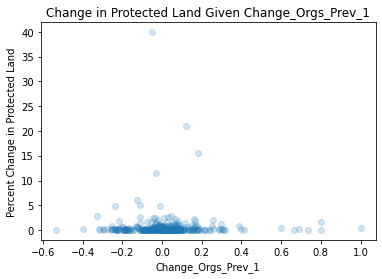

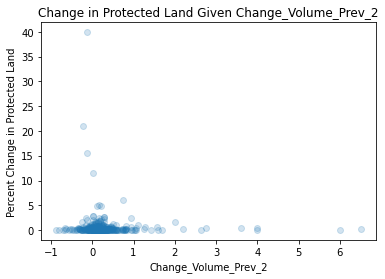

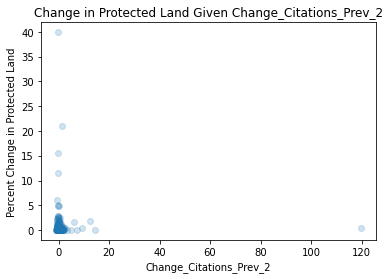

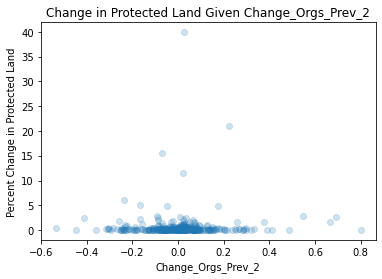

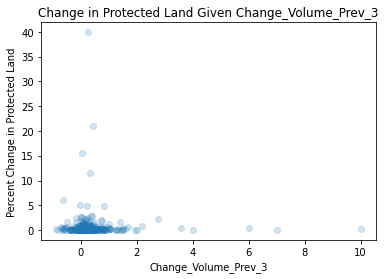

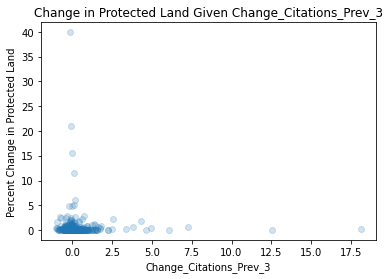

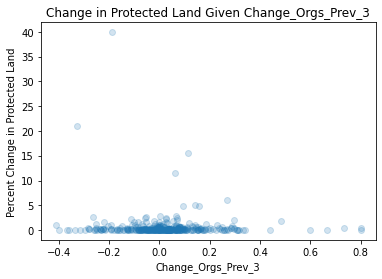

In [17]:
# visualize features vs response
import matplotlib.pyplot as plt

for column_name in X_train_increase.columns:
    plt.scatter(X_train_increase[column_name], y_increase_train, alpha=0.2)
    plt.title(f'Change in Protected Land Given {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Percent Change in Protected Land')
    plt.show()

# Regression

In [ ]:
# run lasso regression over each country, compute the mean model and then measure performance
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
import statsmodels.api as sm

# linear_regr = LinearRegression().fit(X_train_increase, np.ravel(y_increase_train))
# ridge_regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_increase, np.ravel(y_increase_train))
# lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_train_increase, np.ravel(y_increase_train))

# print(f'Linear Regression MSE: {calc_MSE(linear_regr.predict(X_test_increase), np.array(y_increase_test))}')
# print(f'Linear Regression MAE: {calc_MAE(linear_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Linear Regression R^2: {linear_regr.score(X_test_increase, y_increase_test)}')
# print(f'\nRidge Regression MSE: {calc_MSE(ridge_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Ridge Regression MAE: {calc_MAE(ridge_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Ridge Regression R^2: {ridge_regr.score(X_test_increase, y_increase_test)}')
# print(f'\nLasso Regression MSE: {calc_MSE(lasso_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Lasso Regression MAE: {calc_MAE(lasso_regr.predict(X_test_increase), y_increase_test)}')
# print(f'Lasso Regression R^2: {lasso_regr.score(X_test_increase, y_increase_test)}')

model = sm.OLS(np.ravel(y_increase_train), X_train_increase)
results = model.fit()
results.summary()

In [ ]:
linear_regr.predict(X_test_increase)

In [ ]:
X_train_increase

In [ ]:
def confidence_interval(X, y, y_pred):
    # Covariance of coefficient estimates
    mse = np.sum(np.square(y_pred - y)) / y.size
    cov = mse * np.linalg.inv(X.T @ X)
    # Alternatively the covariance could be found using StatsModels:
    # cov = model.cov_params()

    # Calculate variance of f(x)
    var_f = np.diagonal((X @ cov) @ X.T)

    # Derive standard error of f(x) from variance
    se       = np.sqrt(abs(var_f))
    conf_int = 2*se

    return conf_int

# ARIMA

In [ ]:
# train the ARIMA model

import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# run ARIMA on Canada data from 2000 onwards
protected_df = pd.read_csv('protected_land_cleaned.csv')
canada_percentages = protected_df[protected_df['Country'] == 'Canada']
canada_percentages = canada_percentages.reset_index(drop=True)
canada_time_series = pd.DataFrame(dict({'Year': np.array(range(1950, 2022)), 'Percent_Change': np.full_like(np.arange(72), np.nan, dtype=np.double)}))

for index, raw_year in enumerate(canada_percentages['Year']):
    canada_time_series.iloc[raw_year - 1950] = [raw_year, canada_percentages['Value'].iloc[index]]

# interpolate the values
canada_time_series['Percent_Change'] = canada_time_series['Percent_Change'].interpolate()
canada_time_series['Percent_Change'] = canada_time_series['Percent_Change'].pct_change()

train, test = model_selection.train_test_split(canada_time_series['Percent_Change'][1:], train_size=0.8)


arima = pm.auto_arima(train, start_p=1, start_q=1,
                             max_p=10, max_q=10,
                             start_P=0,
                             trace=True, seasonal=False,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


x = np.arange(test.shape[0])
plt.scatter(2021 - len(x) + x, test, color='r', marker='x', label='Actual Values')
plt.plot(2021 - len(x) + x, arima.predict(n_periods=test.shape[0]), label='Forecast')
plt.title('Actual Test Samples vs. Forecasts for Canada')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Chnage in Protected Land Percentage')
plt.show()

In [ ]:
calc_MSE(arima.predict(n_periods=test.shape[0]), np.array(canada_percentages['Value'].tail(len(test) + 1).pct_change())[1:])

Unfortunately, it appears that ARIMA methods have the lowest MSE overall

# Data Visualization

In [ ]:
import geopandas as geopandas

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['Protected Change'] = [np.nan] * len(world)
world['Change Citations'] = [np.nan] * len(world)

for i in range(len(y_train_list)):
    country_index = world.index[world['name'] == countries[i]].tolist()[0]
    world.at[country_index, 'Protected Change'] = y_train_list[i].iloc[-2]
    world.at[country_index, 'Change Citations'] = X_shifted_train_list[i]['Change_Citations'].iloc[-2]

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='Change Citations', ax=ax, missing_kwds={'color': 'lightgrey'}, legend=True, cax=cax)

In [ ]:
# correlation matrices
import seaborn as sb
import matplotlib.pyplot as plt

corr = X_train_agg.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

# Classification

In [ ]:
from sklearn.model_selection import train_test_split
y_train_class = np.array([1 if y_sample > 0 else 0 for y_sample in y_train_agg['Change_Protected_Percent']])
y_test_class = np.array([1 if y_sample > 0 else 0 for y_sample in y_test_agg['Change_Protected_Percent']])

X_class = pd.concat([X_train_agg, X_test_agg])
X_class = X_class.reset_index(drop=True)
y_class = np.concatenate((y_train_class, y_test_class))

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [ ]:
# logistic model
from sklearn.linear_model import LogisticRegression
import sklearn.metrics

log_model = LogisticRegression().fit(X_train, y_train)
print(f'Accuracy: {log_model.score(X_test, y_test)}')
print(f'AUC: {sklearn.metrics.roc_auc_score(y_test, log_model.predict(X_test))}')

In [ ]:
# accuracy of naive classifier
sum(y_class)/len(y_class)

In [ ]:
# svm model
from sklearn.svm import SVC
import sklearn.metrics

svm_model = SVC().fit(X_train, y_train)
print(f'Accuracy: {svm_model.score(X_test, y_test)}')
print(f'AUC: {sklearn.metrics.roc_auc_score(y_test, svm_model.predict(X_test))}')

In [ ]:
# decision tree model
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
decision_tree = decision_tree.fit(X_train, y_train)

print(f'Accuracy: {decision_tree.score(X_test, y_test)}')
print(f'AUC: {sklearn.metrics.roc_auc_score(y_test, decision_tree.predict(X_test))}')

In [ ]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=list(X_train))

In [ ]:
print(r)

In [ ]:
decision_tree.feature_importances_

In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = decision_tree.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=decision_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=decision_tree.classes_)
disp.plot()

In [11]:
X_train['response'] = y_train_agg
X_test['response'] = y_test_agg

X_train_increase = X_train[X_train['response'] > 0.0]
X_test_increase = X_test[X_test['response'] > 0.0]

y_increase_train = X_train_increase['response']
y_increase_test = X_test_increase['response']

X_train_increase = X_train_increase.drop(columns=['response'])
X_test_increase = X_test_increase.drop(columns=['response'])

In [12]:
X_train_increase.to_csv('X_train_increase.csv')
X_test_increase.to_csv('X_test_increase.csv')
y_increase_train.to_csv('y_train_increase.csv')
y_increase_test.to_csv('y_test_increase.csv')

In [13]:
X_train_sparse = X_train_increase[['Change_Citations', 'Change_Citations_Prev_1', 'Change_Citations_Prev_3']]

In [14]:
X_test_sparse = X_test_increase[['Change_Citations', 'Change_Citations_Prev_1', 'Change_Citations_Prev_3']]

In [15]:
X_train_sparse.to_csv('X_train_sparse.csv')
X_test_sparse.to_csv('X_test_sparse.csv')

In [ ]:
# plot ROC curve
y_test = np.ravel(sklearn.preprocessing.label_binarize(y_test, classes=[0, 1]))
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, decision_tree.predict(X_test))
roc_auc = sklearn.metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optimal Decision Tree")
plt.legend(loc="lower right")
plt.show()